# Annotation of DA Peaks

**Created**: 27 January 2021

## Environment

In [1]:
if (!requireNamespace("ComplexHeatmap", quietly=T)) {
    BiocManager::install("ComplexHeatmap")
}

In [2]:
library(tidyverse)
library(data.table)
library(RColorBrewer)
library(ComplexHeatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: grid

ComplexHeatmap version 2.6

## Load Data

In [3]:
homer.annot <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/homer/homer_peak_annotation.txt", sep="\t")

colnames(homer.annot)[1] <- "PeakID"
colnames(homer.annot) <- make.names(colnames(homer.annot))

In [4]:
head(homer.annot)

PeakID,Chr,Start,End,Strand,Peak.Score,Focus.Ratio.Region.Size,Annotation,Detailed.Annotation,Distance.to.TSS,Nearest.PromoterID,Entrez.ID,Nearest.Unigene,Nearest.Refseq,Nearest.Ensembl,Gene.Name,Gene.Alias,Gene.Description,Gene.Type
<chr>,<chr>,<int>,<int>,<chr>,<int>,<lgl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
17:21978952-21981777,17,21978953,21981777,+,509,NA,Intergenic,Intergenic,76390,ENST00000580930,ENSG00000265233,ENST00000580930,NA,NA,ABBA01006766.1,NA,NA,processed_pseudogene
5:134926162-134928758,5,134926163,134928758,+,497,NA,promoter-TSS (ENST00000580862),miRNA-promoter-TSS (ENST00000580862),576,ENST00000498999,ENSG00000247627,ENST00000498999,NA,NA,MTND4P12,NA,NA,processed_pseudogene
2:90399754-90402502,2,90399755,90402502,+,464,NA,Intergenic,Intergenic,35391,ENST00000631132,ENSG00000281904,ENST00000631132,NA,NA,AC233263.6,NA,NA,lncRNA
KI270589.1:41516-44464,KI270589.1,41517,44464,+,461,NA,NA,NA,NA,NA,,,NA,NA,,NA,NA,
16:34062193-34065107,16,34062194,34065107,+,454,NA,Intergenic,Intergenic,12510,ENST00000566112,ENSG00000261197,ENST00000566112,NA,NA,AC133561.3,NA,NA,processed_pseudogene
8:43239225-43242171,8,43239226,43242171,+,442,NA,Intergenic,Intergenic,6237,ENST00000518796,ENSG00000253884,ENST00000518796,NA,NA,AC022616.6,NA,NA,processed_pseudogene


In [5]:
da.peaks <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/da_peak_set.csv", row.names=1)

In [6]:
head(da.peaks)

,Contrast,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,13:50244295-50246227,13,50244295,50246227,4.068530,1.9922172,9.547057,7.190173e-17,4.418153e-11,25.19917
2,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,13:79450967-79452794,13,79450967,79452794,3.720693,2.0688902,9.146720,7.240018e-16,2.224391e-10,23.23470
3,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,9:99470831-99473127,9,99470831,99473127,3.924045,1.2458540,9.056953,1.211705e-15,2.481858e-10,22.79560
4,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,16:19293486-19294933,16,19293486,19294933,5.314531,0.3815736,8.939779,2.369063e-15,3.639301e-10,22.22338
5,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,10:90977043-90978869,10,90977043,90978869,3.431728,1.0461273,8.440246,4.027307e-14,4.949327e-09,19.79878
6,Bulk_B_Stimulated-Bulk_B_Baseline,Bulk_B,7:140375586-140377343,7,140375586,140377343,3.786718,2.0515648,8.237938,1.252067e-13,1.282265e-08,18.82526


In [22]:
up.enriched.motifs <- lapply(unique(da.peaks$Cell.Type), function(cell.type) {

    file.path = paste0("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/homer/", cell.type, "/", cell.type, ".up.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -DB)
})
up.enriched.motifs <- do.call(rbind, up.enriched.motifs)

In [25]:
head(up.enriched.motifs)

,Cell.Type,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Bulk_B,ZNF460,1,MA1596.1,MA1596.1.ZNF460,GCCTCMGCCTCCCRAG,215,40.57,5,0.94,36.00,13.0,8.61e-69,-156.73,7.21e-66,-149.99,4.68e-66,-150.43
2,Bulk_B,ZNF135,2,MA1587.1,MA1587.1.ZNF135,CCTCGACCTCCYRR,222,41.89,29,5.47,7.43,11.0,2.33e-48,-109.68,1.95e-45,-102.95,6.32e-46,-104.07
3,Bulk_B,Jun,3,MA0489.2,MA0489.2.Jun,NVTGACTCATNN,371,70.00,158,29.81,2.34,9.9,4.02e-40,-90.71,3.37e-37,-83.98,7.29e-38,-85.51
4,Bulk_B,FOSL2,4,MA0478.1,MA0478.1.FOSL2,KRRTGASTCAB,430,81.13,228,43.02,1.88,7.5,1.28e-38,-87.25,1.07e-35,-80.52,1.74e-36,-82.34
5,Bulk_B,FOS,5,MA0476.1,MA0476.1.FOS,DVTGASTCATB,372,70.19,169,31.89,2.19,9.5,1.55e-36,-82.45,1.30e-33,-75.72,1.69e-34,-77.76
6,Bulk_B,FOSL1,6,MA0477.2,MA0477.2.FOSL1,NNATGACTCATNN,364,68.68,162,30.57,2.24,9.6,3.60e-36,-81.61,3.01e-33,-74.88,3.18e-34,-77.13


In [26]:
down.enriched.motifs <- lapply(unique(da.peaks$Cell.Type), function(cell.type) {

    file.path = paste0("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/homer/", cell.type, "/", cell.type, ".down.enrichment.tsv")

    if (file.info(file.path)$size == 0) {
        return(data.frame())
    }
    
    read.table(file.path, sep="\t", comment.char="#", header=T) %>%
        dplyr::mutate(Factor=gsub("^[^.]+\\.[^.]+\\.", "", ALT_ID)) %>%
        dplyr::mutate(Cell.Type=cell.type) %>%
        dplyr::select(Cell.Type, Factor, everything(), -DB)
})
down.enriched.motifs <- do.call(rbind, down.enriched.motifs)

In [27]:
head(down.enriched.motifs)

,Cell.Type,Factor,RANK,ID,ALT_ID,CONSENSUS,TP,TP.,FP,FP.,ENR_RATIO,SCORE_THR,PVALUE,LOG_PVALUE,EVALUE,LOG_EVALUE,QVALUE,LOG_QVALUE
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CD8pos_T,ZNF460,1,MA1596.1,MA1596.1.ZNF460,GCCTCMGCCTCCCRAG,138,56.79,0,0.00,139.00,16.0,2.25e-54,-123.53,1.88e-51,-116.80,1.52e-51,-117.01
2,CD8pos_T,ZNF135,2,MA1587.1,MA1587.1.ZNF135,CCTCGACCTCCYRR,113,46.50,1,0.41,57.00,14.0,2.42e-40,-91.22,2.02e-37,-84.49,8.20e-38,-85.39
3,CD8pos_T,Nr2F6,3,MA0728.1,MA0728.1.Nr2F6,RAGGTCAARAGGTCA,91,37.45,3,1.23,23.00,1.7,3.72e-28,-63.16,3.12e-25,-56.43,8.42e-26,-57.74
4,CD8pos_T,MEF2B,4,MA0660.1,MA0660.1.MEF2B,RCTAWAAATAGC,90,37.04,7,2.88,11.40,11.0,1.30e-23,-52.70,1.09e-20,-45.97,2.21e-21,-47.56
5,CD8pos_T,ZNF257,5,MA1710.1,MA1710.1.ZNF257,VDGAGGCRAGRG,154,63.37,58,23.87,2.63,10.0,5.92e-19,-41.97,4.96e-16,-35.24,8.04e-17,-37.06
6,CD8pos_T,OTX2,6,MA0712.2,MA0712.2.OTX2,NDRGGATTARNN,142,58.44,54,22.22,2.60,10.0,1.77e-16,-36.27,1.48e-13,-29.54,2.00e-14,-31.54


## Basic Characteristics of Peaks

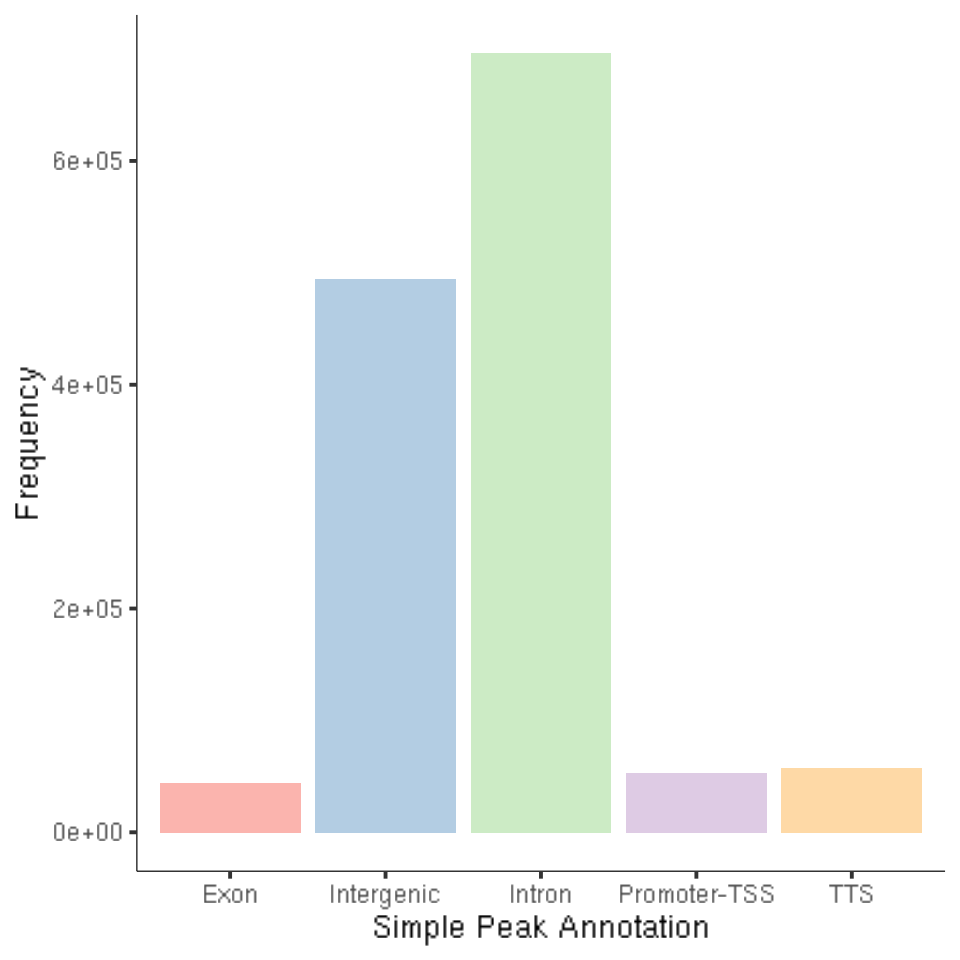

In [7]:
options(repr.plot.width=8, repr.plot.height=8)

homer.annot %>%
    dplyr::filter(!is.na(Annotation)) %>%
    dplyr::mutate(Annotation.Simple=gsub(" \\(.*\\)", "", Annotation)) %>%
    dplyr::group_by(Annotation.Simple) %>%
    dplyr::summarize(Frequency=n()) %>%
    dplyr::mutate(Annotation.Simple=plyr::revalue(Annotation.Simple, c("exon"="Exon", "intron"="Intron", "promoter-TSS"="Promoter-TSS"))) %>%
    ggplot() +
    geom_bar(aes(x=Annotation.Simple, y=Frequency, fill=Annotation.Simple), stat="identity") +
    xlab("Simple Peak Annotation") +
    scale_fill_brewer(palette="Pastel1") + guides(fill="none") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/homer_simple_peak_annotation.svg", width=8, height=8)

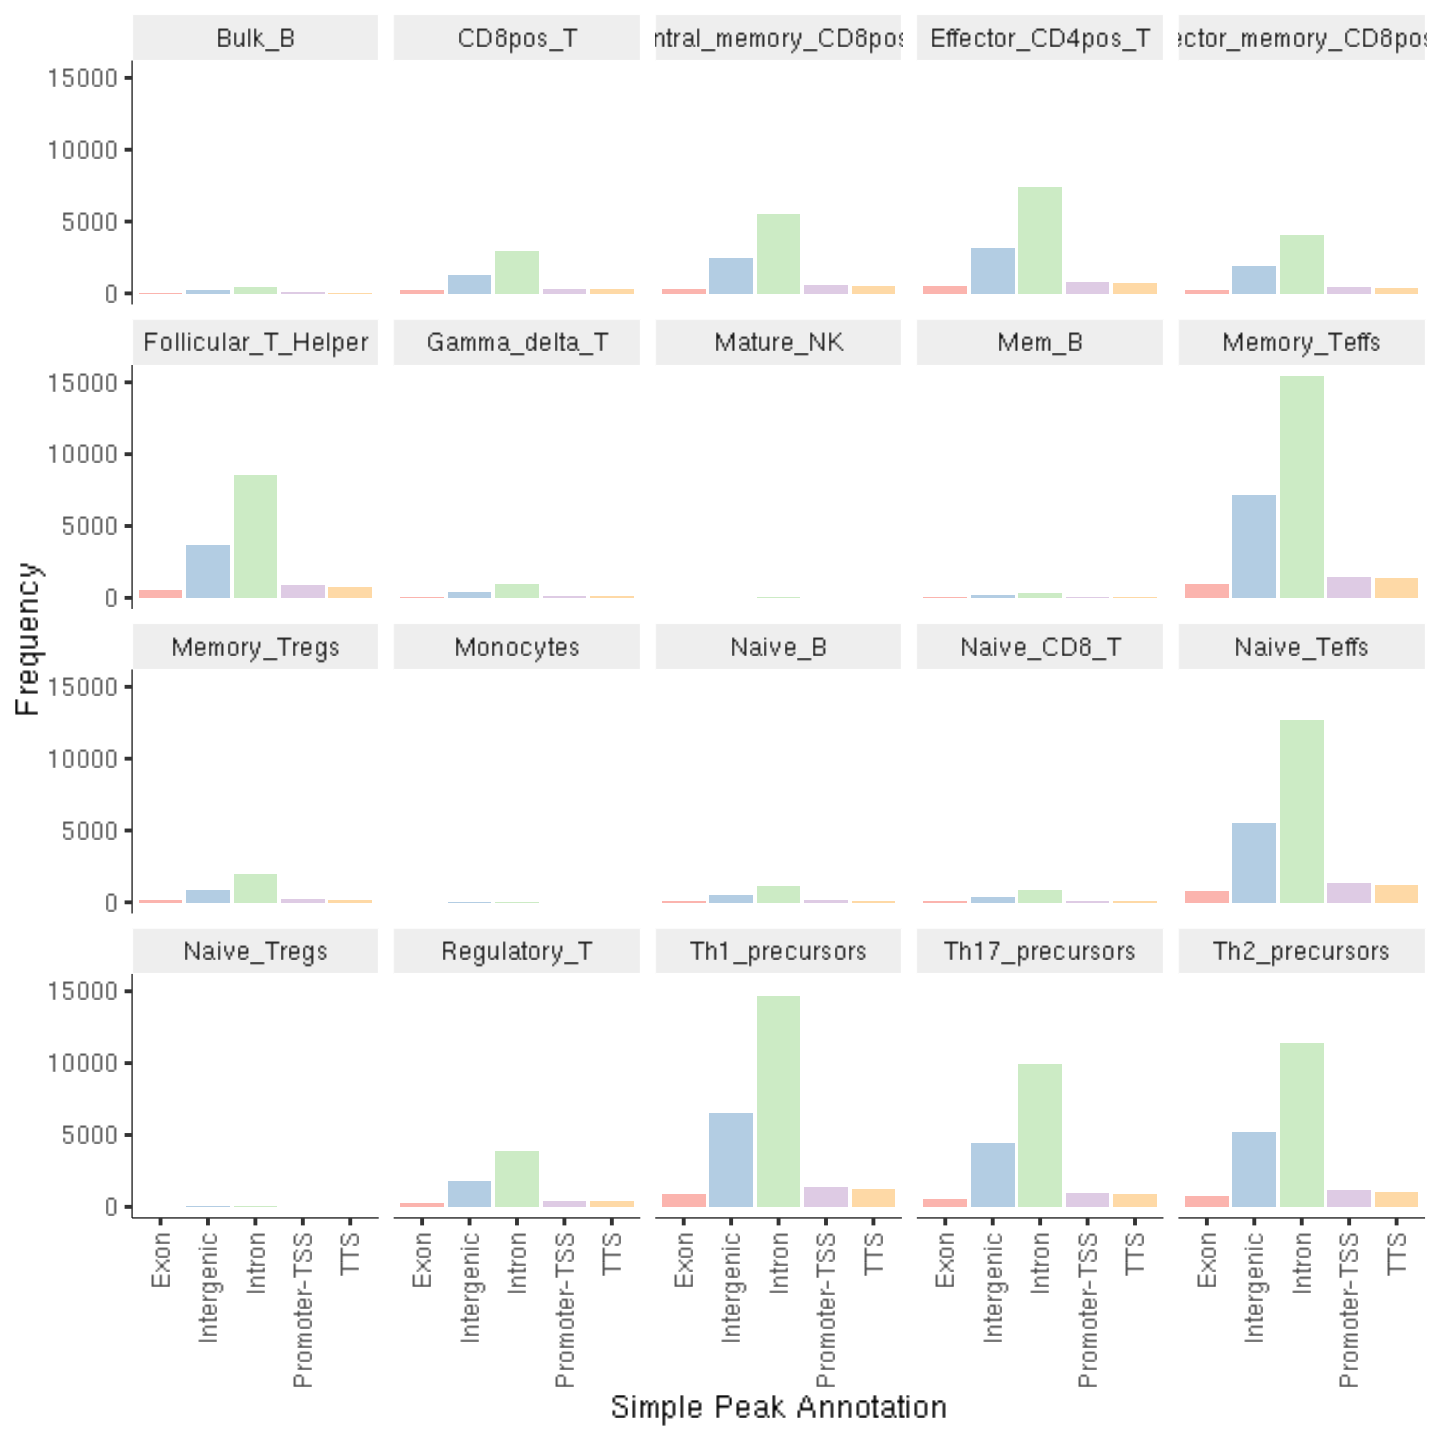

In [8]:
options(repr.plot.width=12, repr.plot.height=12)

homer.annot %>%
    dplyr::filter(!is.na(Annotation)) %>%
    dplyr::mutate(Annotation.Simple=gsub(" \\(.*\\)", "", Annotation)) %>%
    merge(., da.peaks, by.x="PeakID", by.y="Peak.ID") %>%
    dplyr::mutate(Annotation.Simple=plyr::revalue(Annotation.Simple, c("exon"="Exon", "intron"="Intron", "promoter-TSS"="Promoter-TSS"))) %>%
    ggplot() +
    geom_bar(aes(x=Annotation.Simple, fill=Annotation.Simple)) +
    xlab("Simple Peak Annotation") + ylab("Frequency") +
    scale_fill_brewer(palette="Pastel1") + guides(fill="none") +
    facet_wrap(Cell.Type~.) +
    ggplot_theme +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

ggsave("03_Functional_Interpretation/results/homer_simple_peak_annotation_cell_type.svg", width=12, height=12)

## Known Motifs in Cell Types

SEA from the MEME suite checks for the enrichment of motifs in a set of sequenced. I used all the transcription factors for vertebrates from JASPAR as input. I tested for motifs in both more accessible peaks and less accessible peaks. These could highlight transcription factors that drive downstream gene expression.

In [76]:
colors <- colorRampPalette(brewer.pal(9, "Reds"))(101)

plot.mtx <- up.enriched.motifs %>%
    dplyr::mutate(Log2.Enr.Ratio=log2(ENR_RATIO)) %>%
    dplyr::filter(QVALUE < 0.001) %>%
    dplyr::filter(Log2.Enr.Ratio >= 1) %>%
    dplyr::select(ALT_ID, Cell.Type, Log2.Enr.Ratio) %>%
    tidyr::spread(ALT_ID, Log2.Enr.Ratio) %>%
    replace(is.na(.), 0)

rownames(plot.mtx) <- plot.mtx$Cell.Type
plot.mtx <- as.matrix(plot.mtx[,-1])

svg("03_Functional_Interpretation/results/enriched_motifs_more_accessible.svg", width=30, height=5.5)
Heatmap(plot.mtx, col=colors, heatmap_legend_param=list(
    title=bquote("Log"[2]*"(Fold Enrichment)")
))
dev.off()

png 
  2

![](../results/enriched_motifs_more_accessible.svg)

In [70]:
colors <- colorRampPalette(brewer.pal(9, "Blues"))(101)

plot.mtx <- down.enriched.motifs %>%
    dplyr::mutate(Log2.Enr.Ratio=log2(ENR_RATIO)) %>%
    dplyr::filter(QVALUE < 0.001) %>%
    dplyr::filter(Log2.Enr.Ratio >= 1) %>%
    dplyr::select(ALT_ID, Cell.Type, Log2.Enr.Ratio) %>%
    tidyr::spread(ALT_ID, Log2.Enr.Ratio) %>%
    replace(is.na(.), 0)

rownames(plot.mtx) <- plot.mtx$Cell.Type
plot.mtx <- as.matrix(plot.mtx[,-1])

svg("03_Functional_Interpretation/results/enriched_motifs_less_accessible.svg", width=30, height=5.5)
Heatmap(plot.mtx, col=colors, heatmap_legend_param=list(
    title=bquote("Log"[2]*"(Fold Enrichment)")
))
dev.off()

png 
  2

![](../results/enriched_motifs_less_accessible.svg)